# JackKnife W/ Kmeans

Just following treecorr Kmeans examples.
https://rmjarvis.github.io/TreeCorr/_build/html/patches.html
https://rmjarvis.github.io/TreeCorr/_build/html/cov.html#covariance-estimates

In [1]:
import numpy as np, time, astropy.io.fits, os, sys
import matplotlib.pylab as plt

In [86]:
import treecorr
from set_bins_files import SetupFiles, config 

## Load Data

In [3]:
from util import load_data, apply_bin_cut
print('Load Data')
rm_all, ran_all = load_data()

Load Data


In [52]:
data = rm_all

Nran_size = 30*len(data)
cut = np.random.randint(len(ran_all),size=Nran_size)
randoms = ran_all[cut]

In [7]:
from time import time
n_patches = 10
config['verbose'] = 1

In [8]:
t0 = time()
cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], npatch=n_patches, 
                       ra_units='degrees', dec_units='degrees')

rcat = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], patch_centers=cat.patch_centers,
                        ra_units='degrees', dec_units='degrees')
tk = time()-t0
t02 = time()
print('Kmeans with %i paches takes %.2f sec'%(n_patches, tk))

# process data catalog
dd = treecorr.NNCorrelation(config, var_method='jackknife')
dd.process(cat)

# process random catalog (it takes longer)
rr = treecorr.NNCorrelation(config)
rr.process(rcat)

# process data x random
dr = treecorr.NNCorrelation(config)
dr.process(cat, rcat)

tpr = time()-t02
print('process catalogs: %.2f sec'%tpr)
# return Landy & Szalay estimator
xi, varxi = dd.calculateXi(rr=rr, dr=dr)

cov = dd.cov
r   = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)

tt = time()-t0
print('It takes %.2f sec to compute the JK cov for %i patches'%(tt, n_patches))

Kmeans with 10 paches takes 2.89 sec
process catalogs: 118.67 sec
It takes 121.57 sec to compute the JK cov for 10 patches


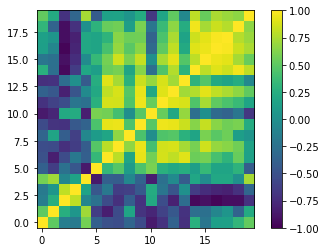

In [9]:
plt.imshow(np.corrcoef(cov), origin='lower', vmin=-1., vmax=1.)
plt.colorbar()

In [10]:
field = cat.getNField()
labels = field.run_kmeans(n_patches)[0]

In [11]:
labels

array([5, 5, 5, ..., 8, 8, 8])

# Stats

In [12]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, n_patches))
np.random.shuffle(colors)

In [13]:
import skymapper as skm

def plot_proj(ra, dec, labels, Npoints=10000):
    idx = np.random.randint(len(ra), size=Npoints)
    # define the best Albers projection for the footprint
    # minimizing the variation in distortion
    crit = skm.stdDistortion
    proj = skm.WagnerIV.optimize(ra[idx], dec[idx], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep,)

    # add scatter plot
    map.scatter(ra[idx], dec[idx], c=colors[labels[idx]], s=25, edgecolor='w', facecolor='None')


    # # focus on relevant region
    map.focus(ra[idx], dec[idx], pad=0.1)

    map.title('DES K-Means')
    
    # hide x-ticks
    ax = map.ax
    labels = [item.get_text() for item in ax.get_xticklabels()]

    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)
    

optimizing parameters of WagnerIV to minimize stdDistortion
best objective 0.089421 at WagnerIV(12.378543530735543)


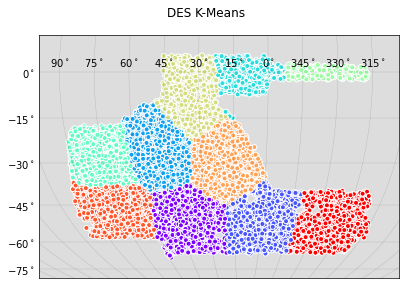

In [14]:
plot_proj(data['ra'], data['dec'], labels)

In [15]:
cluster_sizes = np.bincount(labels)
print('Average cluster size: %i'%(np.median(cluster_sizes)))

Average cluster size: 27931


In [74]:
frac_th = 0.6

frac = cluster_sizes/np.median(cluster_sizes)
bad_groups = np.where(np.abs(1-frac)>=(1-frac_th))[0]
bad_groups

array([ 7, 36])

Text(0.5, 1.0, 'Average Fraction Of Objectes In Each Patch')

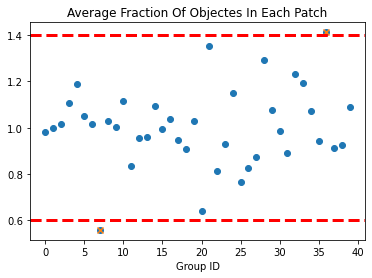

In [75]:
plt.scatter(range(n_patches),frac)
plt.scatter(bad_groups,frac[bad_groups],marker='x')
plt.axhline(frac_th,color='r',lw=3, ls='--')
plt.axhline(2-frac_th,color='r',lw=3, ls='--')

plt.xlabel('Group ID')
plt.title('Average Fraction Of Objectes In Each Patch')

# Covariance

Study how the covariance changes with the number of patches

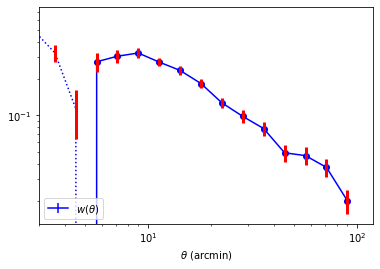

In [76]:
plt.scatter(r, xi, color='blue')
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='r', lw=3, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='r', lw=3, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([3,120])
plt.show()

In [83]:
def compute_angular_correlation_jk_cov(n_patches):
    t0 = time()
    cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], npatch=n_patches, 
                           ra_units='degrees', dec_units='degrees')

    rcat = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], patch_centers=cat.patch_centers,
                            ra_units='degrees', dec_units='degrees')

    # process data catalog
    dd = treecorr.NNCorrelation(config, var_method='jackknife')
    dd.process(cat)

    # process random catalog (it takes longer)
    rr = treecorr.NNCorrelation(config)
    rr.process(rcat)

    # process data x random
    dr = treecorr.NNCorrelation(config)
    dr.process(cat, rcat)

    # return Landy & Szalay estimator
    xi, varxi = dd.calculateXi(rr=rr, dr=dr)

    cov = dd.cov
    r   = np.exp(dd.meanlogr)
    sig = np.sqrt(varxi)

    tt = time()-t0
    print('%i patches: %.2f sec'%(n_patches, tt))
    # clean memory
    rcat = cat = 0
    rr = dd = 0
    return r, xi, sig, cov

In [93]:
kmeans = dict()
npatches = np.array([5, 10, 20, 50, 100, 300, 500])
# npatches = np.array([5, 50, 150])
for ni in npatches:
    r, xi, sig, cov = compute_angular_correlation_jk_cov(ni)
    kmeans['%i_sig'%ni] = sig
    kmeans['%i_cov'%ni] = cov

5 patches: 7.26 sec
10 patches: 9.81 sec
20 patches: 14.00 sec
50 patches: 26.04 sec
100 patches: 44.16 sec
300 patches: 218.52 sec
500 patches: 638.67 sec


Text(0.5, 0, '$\\theta$ (arcmin)')

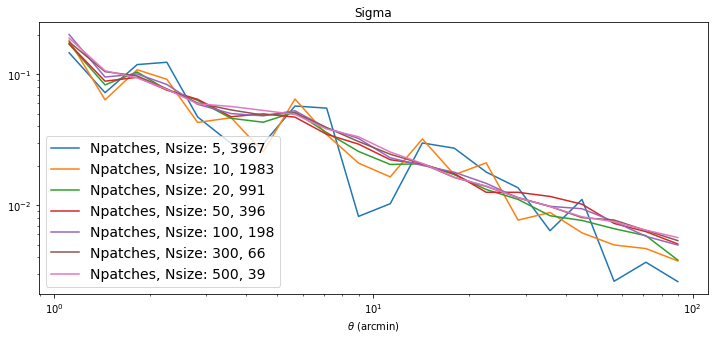

In [94]:
plt.figure(figsize=(12,5))
for ni in npatches:
    plt.loglog()
    plt.plot(r, kmeans['%i_sig'%ni], label='Npatches, Nsize: %i, %i'%(ni, len(data)/ni))
plt.legend()
plt.legend(fontsize=14)
plt.title('Sigma')
plt.xlabel(r'$\theta$ (arcmin)')

With more than 20 patches the algorithms converges to a stable solution.

## Redshift-Space Correlation

In [17]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.H(0)  


<Quantity 69.32 km / (Mpc s)>

In [45]:
from scipy.interpolate import interp1d
h = cosmo.H(0).value/100.
zgrid = np.linspace(0., 10., 10000)
rcomov = cosmo.comoving_distance(np.array(zgrid)).value/h
get_rcomov = interp1d(zgrid, rcomov)

In [53]:
data['rcomov'] = get_rcomov(data['z_lambda'])
randoms['rcomov'] = get_rcomov(randoms['ztrue'])

In [54]:
# _ = plt.hist(randoms['rcomov'])

In [76]:
# load data and random catalogs
cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], r=data['rcomov'],
                       npatch=n_patches, ra_units='degrees', dec_units='degrees')

rcat = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], r=randoms['rcomov'],
                        patch_centers=cat.patch_centers, ra_units='degrees', dec_units='degrees')


In [72]:
# cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], z_col=data['z_lambda'],
#                        npatch=n_patches, ra_units='degrees', dec_units='degrees')

# rcat = treecorr.Catalog(ra=randoms['ra'], dec=randoms['dec'], z_col=randoms['ztrue'],
#                         patch_centers=cat.patch_centers, ra_units='degrees', dec_units='degrees')


In [79]:
cat

treecorr.Catalog(ra=array([0.7891214 , 0.78333992, 0.78332439, ..., 5.53394232, 5.53715556,
       5.53530248]),ra_units='rad',dec=array([ 0.00721885,  0.00504999,  0.00573083, ..., -0.03718445,
       -0.03637745, -0.03237339]),dec_units='rad',r=array([1550.31660313, 1155.9604631 , 2124.22184057, ...,  773.06943034,
       3278.45664899, 3264.85289906]),patch=array([9, 9, 9, ..., 1, 1, 1]))

In [98]:
rmax = 300

n3_config = dict()
n3_config['nbins'] = 12
n3_config['max_sep'] = rmax
n3_config['min_sep'] = 3

n3_config['min_rpar'] = -rmax
n3_config['max_rpar'] = rmax


In [99]:
n3_config

{'nbins': 12, 'max_sep': 300, 'min_sep': 5, 'min_rpar': -300, 'max_rpar': 300}

In [100]:
t0 = time()
# process data catalog
dd = treecorr.NNCorrelation(n3_config, var_method='jackknife')
dd.process(cat)

# process random catalog (it takes longer)
rr = treecorr.NNCorrelation(n3_config)
rr.process(rcat)

# process data x random
dr = treecorr.NNCorrelation(n3_config)
dr.process(cat, rcat)

# return Landy & Szalay estimator
xi, varxi = dd.calculateXi(rr=rr, dr=dr)

cov = dd.cov
r   = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)
tt = time()-t0
print('It takes %.2f sec to compute the JK cov for %i patches'%(tt, n_patches))

It takes 145.82 sec to compute the JK cov for 10 patches


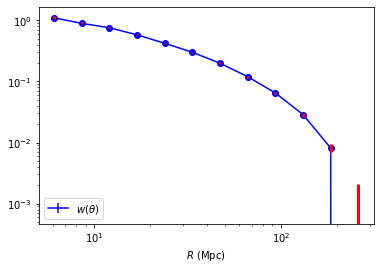

In [103]:
plt.scatter(r, xi, color='blue')
plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='r', lw=3, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='r', lw=3, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$R$ (Mpc)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
# plt.xlim([3,120])
plt.show()

In [108]:
cat.ra.size

256481

In [257]:
rm = np.logspace(np.log10(3), np.log10(40), 10)
rm

array([ 3.        ,  4.00050159,  5.334671  ,  7.11378661,  9.48623822,
       12.6499037 , 16.86865331, 22.49435814, 29.99623852, 40.        ])